In [26]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

# 2. Load Dataset
r="data/dataset.csv"  
df=pd.read_csv(r)  
df.head()



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [27]:
# Cell 3: Preprocessing
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.dropna(inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [28]:
# Cell 4: Encode Categorical Variables
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [29]:
# Cell 5: Train-Test Split
X = df.drop('Churn', axis=1)
y = df['Churn']
# Save feature names for later use in the app
feature_names = list(X.columns)
joblib.dump(feature_names, 'models/feature_names.pkl')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Cell 6: Scale Features
import joblib
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'models/scaler.pkl')


['models/scaler.pkl']

In [31]:
# Cell 7: Train Model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)
joblib.dump(model, 'models/xgb_model.pkl')


['models/xgb_model.pkl']

In [32]:
# Cell 8: Evaluate
y_pred = model.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.50      0.54       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.69      1407
weighted avg       0.76      0.77      0.77      1407

Confusion Matrix:
 [[903 130]
 [188 186]]
ROC AUC Score: 0.6857395778869498


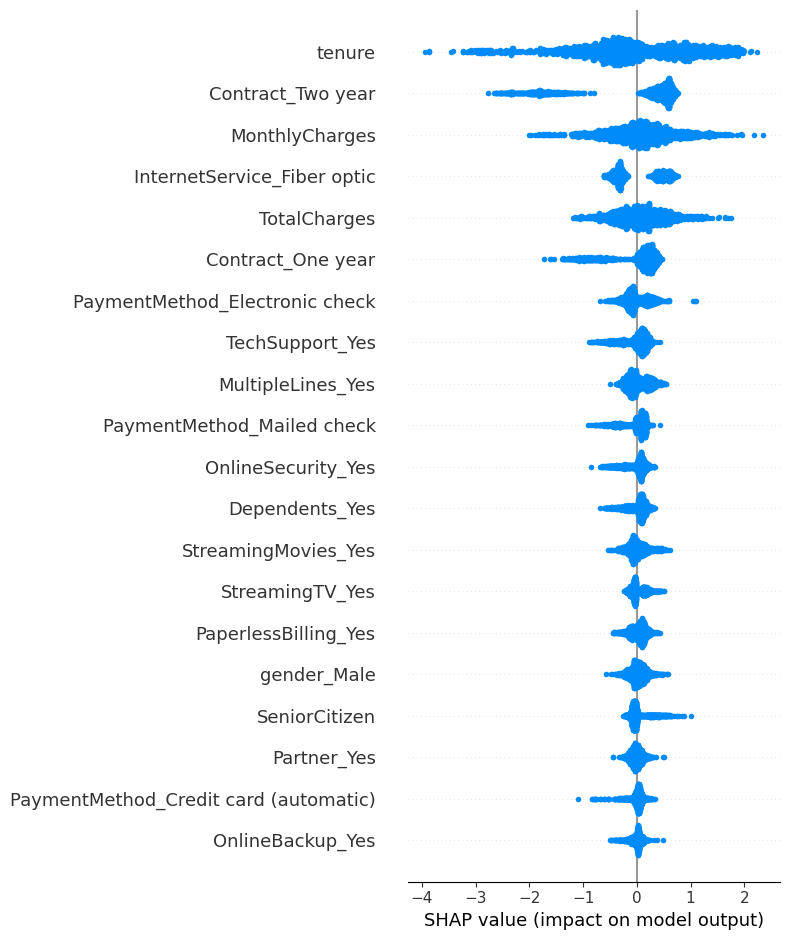

In [33]:
# Cell 9: SHAP Explainability
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X.columns, show=False)
plt.savefig("images/shap_summary_plot.png", bbox_inches='tight')
